# Modeling Market Risk

Market risk is the risk arising from changes in financial indicators, such as the exchange rate, interest rate, inflation, etc. These financial indicators are often interrelated.

Market risk is the risk of losses in on- and off-balance-sheet positions arising from movements in market prices.

The most prominent and widely accepted tools to manage market risk are **value at risk (VAR)** and **expected shortfall (ES)**.

1. Do traditional models fail in finance?
Their main challenge is being unable to address the complexity of the financial system, while their underlying assumptions might be incorrect. Consequently, they are starting to be replaced by ML models.

2. What makes ML models different?
In contrast to traditional models, ML models try to unveil the associations between variables, identify key variables, and enable us to find out the impact of the variables on the dependent variable without need for theory or assumptions. They discover theories rather than assume them.

## Value at Risk (VaR)

The method by which market risk is computed is known as VaR. Its appeal come from two characteristics:
1. It provides a common consistent measure of risk across different positions and risk factors - and that measure allows institutions to manage their risks in new ways not possible before.
2. It accounts the correlations between different risk factors; if two risks offset each other, the VaR allows for this offset by telling us the overall risk is low.

It addresses the most common question an investor has: *What is the maximum expected loss of my investment?*

It measures the worst expected loss for a company over a given period and a predefined confidence interval. For instance, a VaR of an invenstment of $1M with 95% confidence interval means there is a 5% chance of a loss greater than $1M in a day.

The VaR components then:
1. Confidence interval
2. Time period
3. Standard deviation

VaR characteristics:
1. Needs an estimation of the probability of loss
2. Concentrates on potential losses; loss projection
3. Can be estimated via three approaches:
  - Variance-covariance VaR
  - Historical simulation VaR
  - Monte Carlo VaR

We can either work with a single asset or a portfolio; with the latter, we need to consider correlation structure and portfolio variance.

### Variance-Covariance Method (parametric method)

Observarions are assumed to be normally distributed. This parametric form assumption makes the application of this method easy.

Historical data is used to calculate correlation, mean, and standard deviation.

Having high kurtosis leads to fat tails, which the variance-covariance method is unable to capture. Therefore it cannot estimate extreme negative returns that are likely to occur, especially in times of crisis.

*Pros:*
  - Easy to calculate
  - Does not require a large number of samples

*Cons:*
  - Obervations are normally distributed
  - Does not work well with nonlinear structures
  - Requires computing the covariance matrix

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
from scipy.stats import norm
import requests
from io import StringIO
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

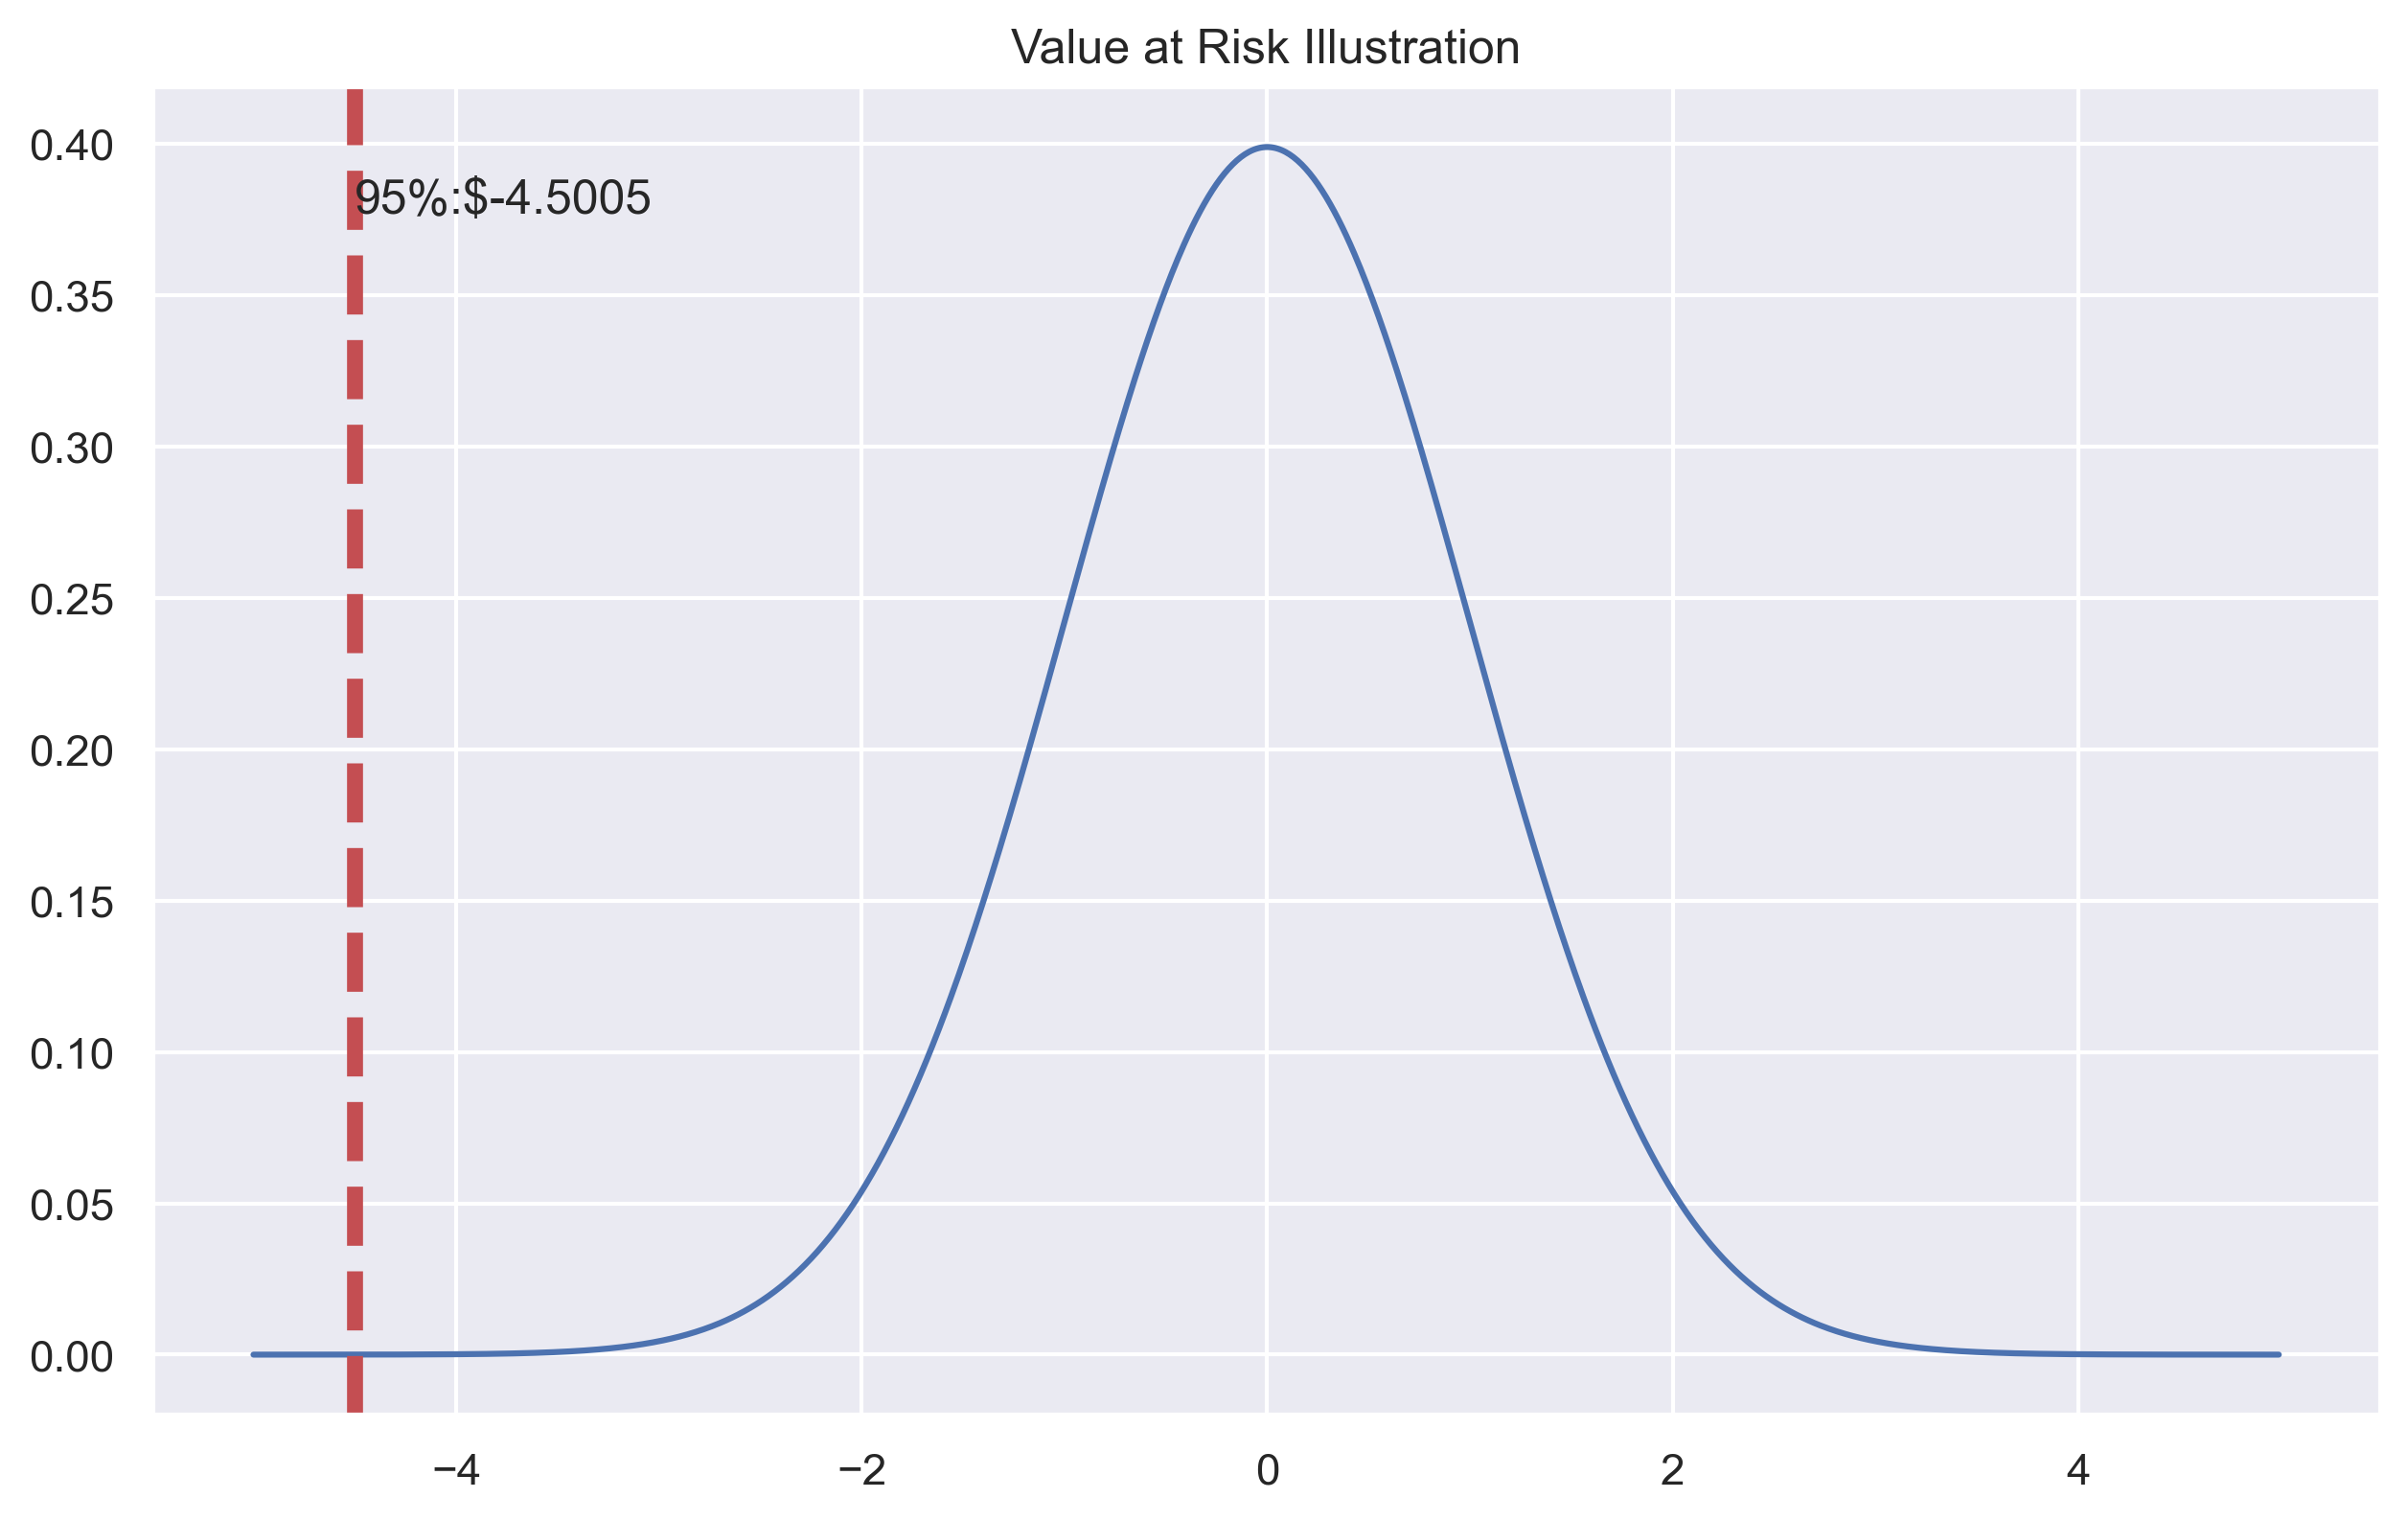

In [3]:
# Single Asset

mean = 0
std_dev = 1
x = np.arange(-5, 5, 0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x, y)
min_ylim, max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed',
            linewidth=4)
plt.title('Value at Risk Illustration')
plt.show()

In [4]:
def getDailyData(symbol):
        parameters = {'function': 'TIME_SERIES_DAILY_ADJUSTED', 
                      'symbol': symbol,
                       'outputsize':'full',
                       'datatype': 'csv', 
                       'apikey': 'insert your api key here'}

        response = requests.get('https://www.alphavantage.co/query',
                                params=parameters)

        csvText = StringIO(response.text)
        data = pd.read_csv(csvText, index_col='timestamp')
        return data

In [5]:
# Multiple Assets
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    stock3.append(getDailyData(symbol)[::-1]['close']
                  ['2020-01-01': '2020-12-31'])
stocks = pd.DataFrame(stock3).T
stocks.columns = symbols

In [6]:
stocks.head()

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,135.42,160.62,60.84
2020-01-03,134.34,158.62,60.10
2020-01-06,134.10,159.03,59.93
2020-01-07,134.19,157.58,58.93
2020-01-08,135.31,160.09,58.97


In [7]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

,IBM,MSFT,INTC
timestamp,,,
2020-01-03,-0.008007,-0.012530,-0.012238
2020-01-06,-0.001788,0.002581,-0.002833
2020-01-07,0.000671,-0.009160,-0.016827
2020-01-08,0.008312,0.015803,0.000679
2020-01-09,0.010513,0.012416,0.005580
...,...,...,...
2020-12-24,0.006356,0.007797,0.010679
2020-12-28,0.001042,0.009873,0.000000
2020-12-29,-0.008205,-0.003607,0.048112


In [8]:
stocks_returns_mean = stocks_returns.mean()
weights  = np.random.random(len(stocks_returns.columns))
weights /= np.sum(weights)
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [9]:
initial_investment = 1e6
conf_level = 0.95

In [10]:
def VaR_parametric(initial_investment, conf_level):
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment - initial_investment * 
                     (1 + alpha))[j]
        print("Parametric VaR result for {} is {} "
              .format(i, VaR_param))
    VaR_param = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_param

In [11]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for IBM is 41770.82898259978 
Parametric VaR result for MSFT is 40189.16966715653 
Parametric VaR result for INTC is 42273.92013218615 
--------------------------------------------------


array([41770.8289826 , 40189.16966716, 42273.92013219])

VaR changes depending on the time horizon in the sense that holding an asset for a longer period of ftime increases its risk. VaR increases in relation to holding time by the amount of $\sqrt t$.

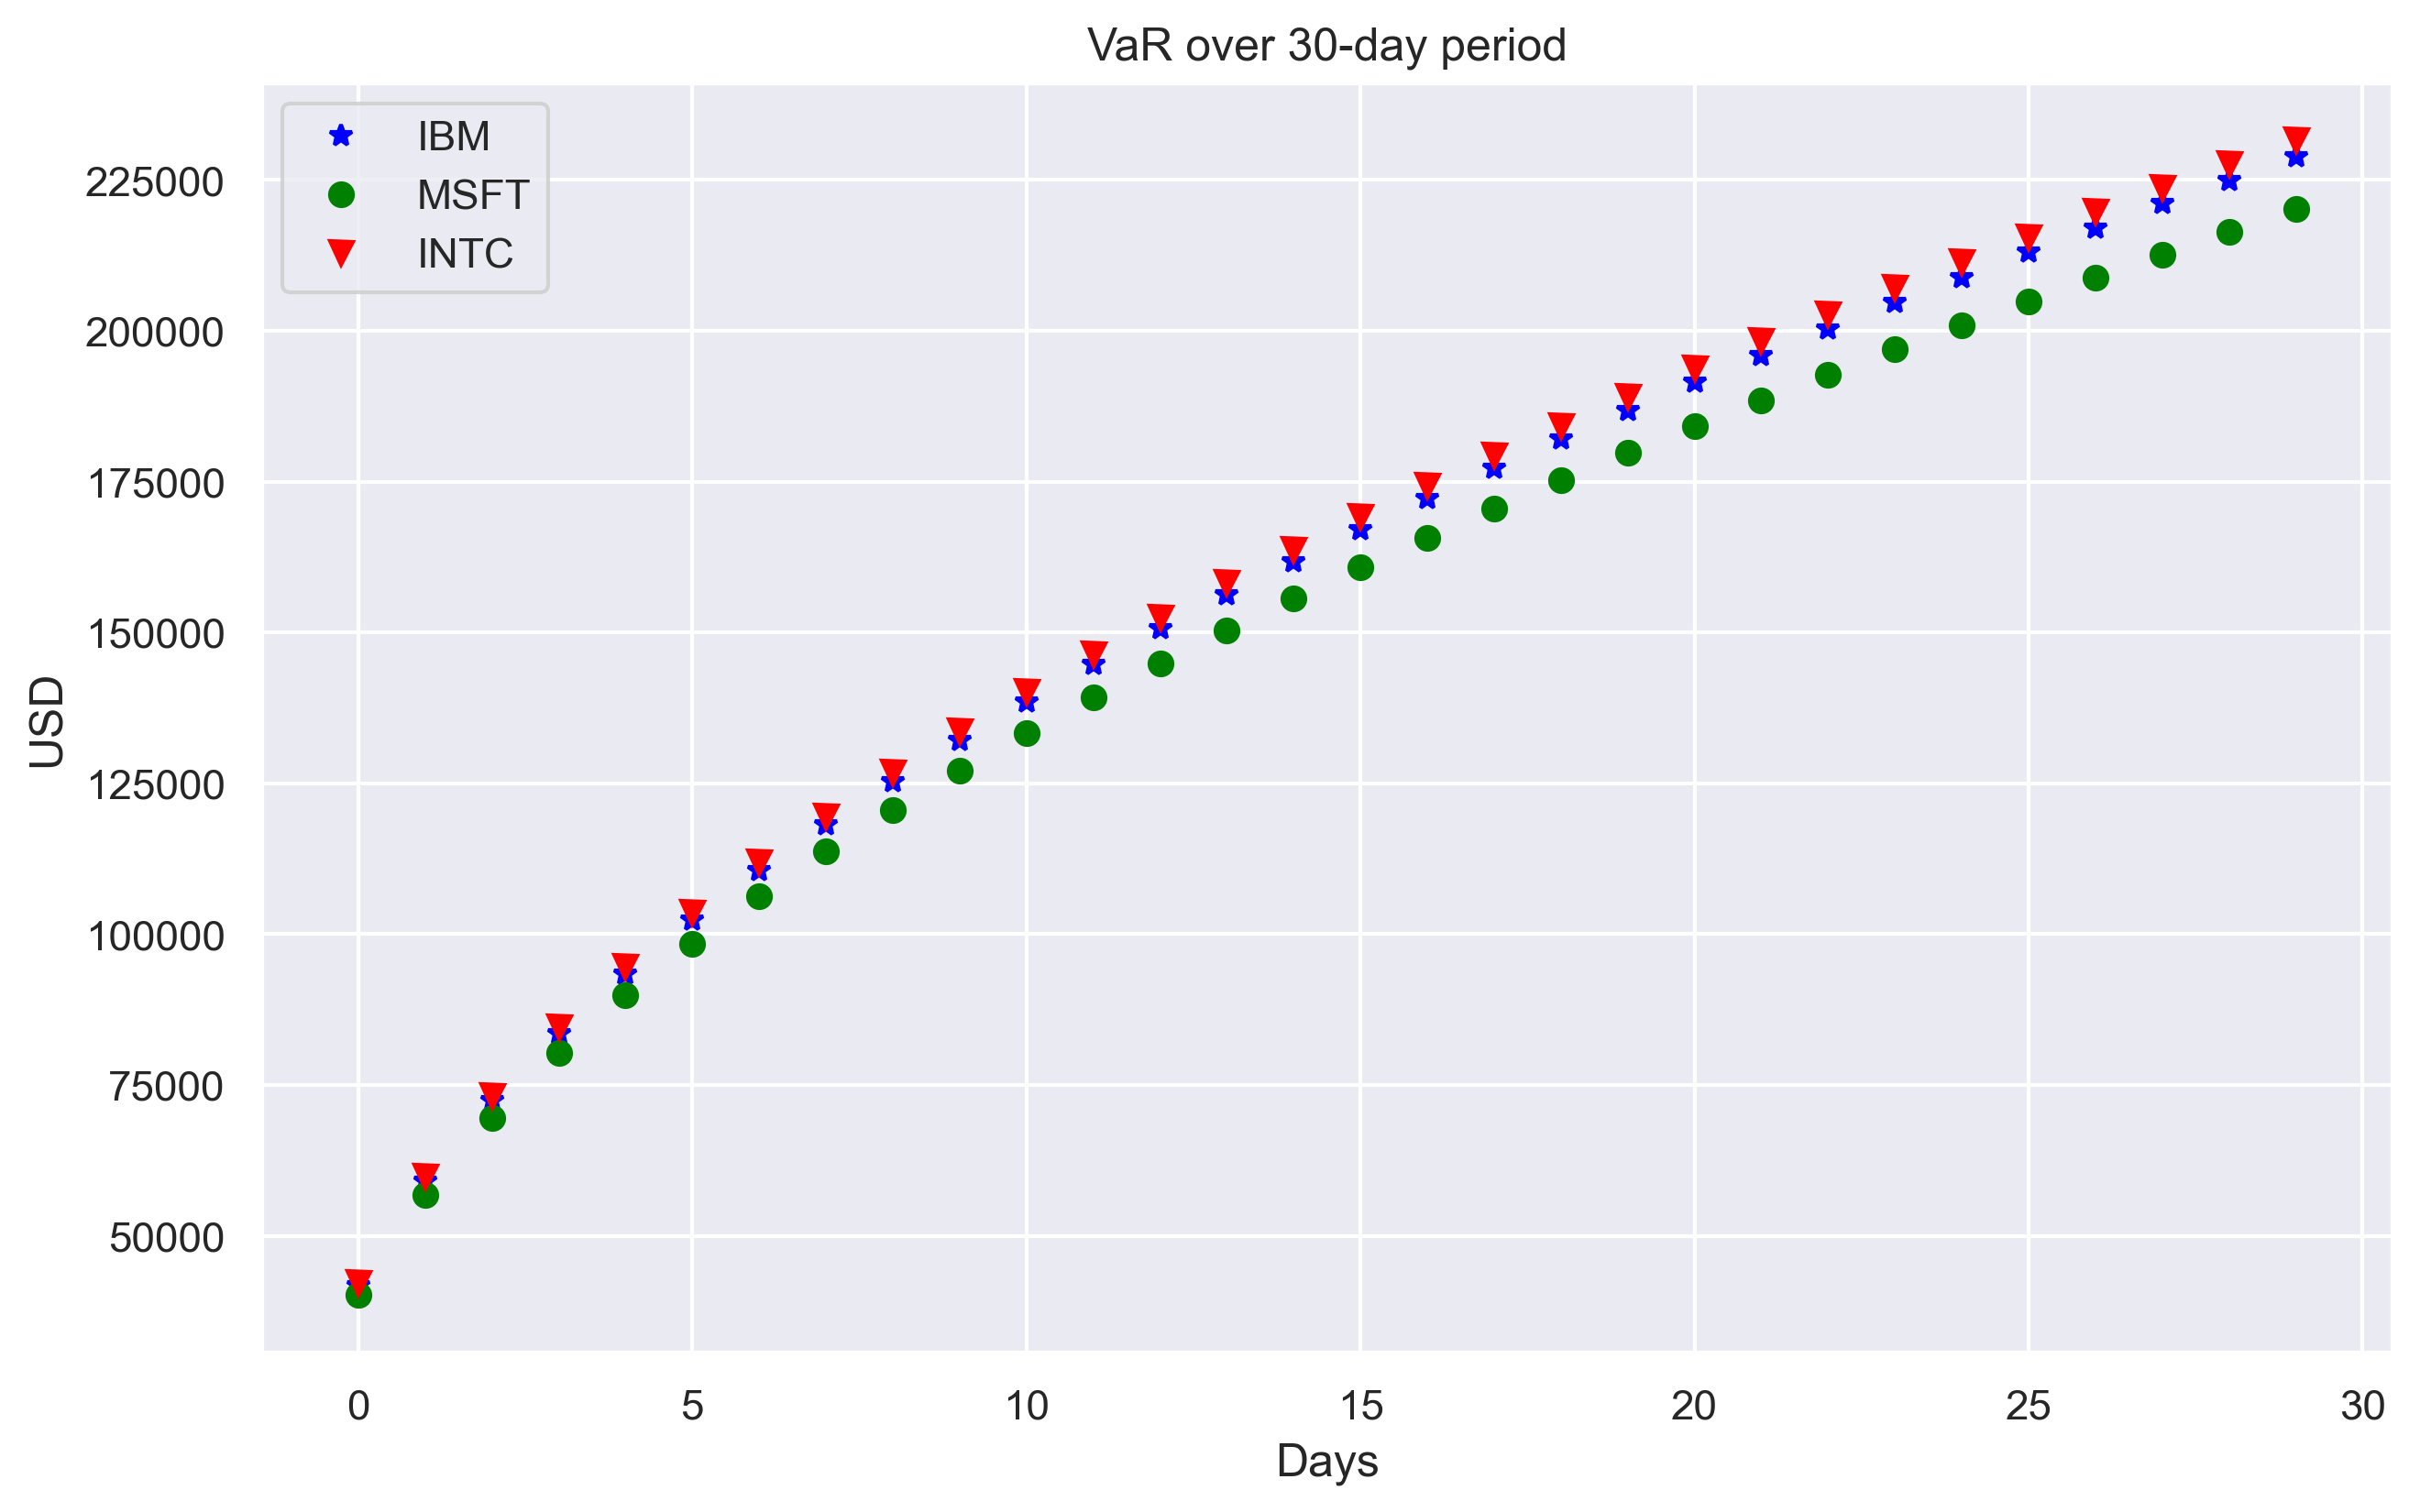

In [12]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon + 1):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
         c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
         c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
         c='red', marker='v', label='INTC')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
plt.legend()
plt.show()

## Historical Simulation VaR

This is an empirical method: Instead of using a parametric approach, we find the percentile, which is the Z-table equivalent of the variance-covariance method. If the confidence interval is 95%, 5% will be used in lieu of the Z-table values, and we will multiply this percentile by the initial investment.

*Steps:*
1. Obtain the asset returns of the portfolio (or individual asset)
2. Find the corresponding return percentile based on confidence interval
3. Multiply this percentile by initial investment

This method assumes future price changes have a similar pattern as history; i.e. no structural break.

*Pros:*
  - No distribution assumptions
  - Works well with nonlinear structures
  - Easy to calculate

*Cons:*
  - Requires a large sample size
  - Needs high computing power

In [13]:
def VaR_historical(initial_investment, conf_level):
    Hist_percentile95 = []
    for i, j in zip(stocks_returns.columns,
                    range(len(stocks_returns.columns))):
        Hist_percentile95.append(np.percentile(stocks_returns.loc[:, i],
                                               5))
        print("Based on historical values 95% of {}'s return is {:.4f}"
              .format(i, Hist_percentile95[j]))
        VaR_historical = (initial_investment - initial_investment *
                          (1 + Hist_percentile95[j]))
        print("Historical VaR result for {} is {:.2f} "
              .format(i, VaR_historical))
        print('--' * 35)

In [14]:
VaR_historical(initial_investment,conf_level)

Based on historical values 95% of IBM's return is -0.0371
Historical VaR result for IBM is 37081.53 
----------------------------------------------------------------------
Based on historical values 95% of MSFT's return is -0.0426
Historical VaR result for MSFT is 42583.68 
----------------------------------------------------------------------
Based on historical values 95% of INTC's return is -0.0425
Historical VaR result for INTC is 42485.39 
----------------------------------------------------------------------


## Monte Carlo VaR

Monte Carlo relies on repeated random samples from a given distribution. Its application is similar to the Historical VaR method, except it does not use historical observations. Rather, it generates random samples from a given distribution.

Monte Carlo helps decision makers by providing links between possible outcomes and probabilities, which makes it an efficient and applicable tool in finance.

**Monte Carlo defined:**  

Let $X_1, X_2, \ldots, X_n$ be a set of independent and identically distributed random variables, and $f(X)$ be a real-valued function. 

The law of large numbers states that $E(f(X)) = \frac{1}{N}\sum_{i=1}^N f(X_i)$.

Monte Carlo, then, generates random samples and calculates their mean:
1. Define the domain
2. Generate random samples
3. Iterate and aggregate the result

In [15]:
x = np.random.uniform(-1, 1, 100) # Domain is between -1 and 1 on x axis
y = np.random.uniform(-1, 1, 100) # Domain is between -1 and 1 on y axis

In [23]:
sample = 100    
def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) <= 1:
            point_inside_circle += 1 
    print('pi value is {}'.format(4 * point_inside_circle/sample))

In [24]:
pi_calc(x,y)

pi value is 3.12


In [25]:
x = np.random.uniform(-1, 1, 1000000)
y = np.random.uniform(-1, 1, 1000000)

In [26]:
sample = 1000000   

def pi_calc(x, y):
    point_inside_circle = 0
    for i in range(sample):
        if np.sqrt(x[i] ** 2 + y[i] ** 2) < 1:
            point_inside_circle += 1 
    print('pi value is {:.2f}'.format(4 * point_inside_circle/sample))

In [27]:
pi_calc(x,y)

pi value is 3.14


In [28]:
sim_data = pd.DataFrame([])
num_reps = 1000
n = 100
for i in range(len(stocks.columns)):
    mean = np.random.randn(n).mean()
    std = np.random.randn(n).std()
    temp = pd.DataFrame(np.random.normal(mean, std, num_reps))
    sim_data = pd.concat([sim_data, temp], axis=1)
sim_data.columns = ['Simulation 1', 'Simulation 2', 'Simulation 3']

In [29]:
sim_data

,Simulation 1,Simulation 2,Simulation 3
0,-1.377089,0.010236,1.731705
1,-0.133228,-0.608119,-1.238311
2,-1.124326,0.558606,-0.353405
3,0.179546,-0.407334,0.596654
4,0.163674,0.091033,-0.776647
...,...,...,...
995,-0.395504,-0.296251,-0.163534
996,0.024622,-1.529714,0.399265
997,0.074051,0.274911,0.465945
998,-1.122260,0.284090,0.055018


In [30]:
def MC_VaR(initial_investment, conf_level):
    MC_percentile95 = []
    for i, j in zip(sim_data.columns, range(len(sim_data.columns))):
        MC_percentile95.append(np.percentile(sim_data.loc[:, i], 5))
        print("Based on simulation 95% of {}'s return is {:.4f}"
              .format(i, MC_percentile95[j]))
        VaR_MC = (initial_investment - initial_investment * 
                  (1 + MC_percentile95[j]))
        print("Simulation VaR result for {} is {:.2f} "
              .format(i, VaR_MC))
        print('--' * 35)

In [31]:
MC_VaR(initial_investment, conf_level)

Based on simulation 95% of Simulation 1's return is -1.7742
Simulation VaR result for Simulation 1 is 1774224.09 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 2's return is -1.5479
Simulation VaR result for Simulation 2 is 1547921.23 
----------------------------------------------------------------------
Based on simulation 95% of Simulation 3's return is -1.2515
Simulation VaR result for Simulation 3 is 1251503.31 
----------------------------------------------------------------------


## Denoising

There are generally two types of information in the market:
  1. Noise
  2. Signal

The noise trader is driven by random behavior, whereas the signal trader exploits market information. Investors who cannot distringuish between noise and signal can fail to gain profit and/or assess risk properly.

How do we separate noise from signal?

### The Marcenko-Pastur Theory

The Marchenko-Pastur theorem allows us to extract signal from noise using eiegenvalues of covariance matrices, which helps have homogenous covariance matrices.

*Eigenvalue* and *eigenvector* have special meanings in a financial contrxt:
  - Eigenvectors represent the variance in covariance matrices
  - Eigenvalues represent the magnitude of the variance in covariance matrices
  - Specifically, the largest eigenvector corresponds to largest variance, and the magnitude is represented by its corresponding eigenvalue

To differentiate noise and signal, we fit the Marchenko-Pastur theorem probablility density function to the noise covariance.

Below, we generate the PDF of a Marchenko-Pastur distribution and kernel density, allowing us to model a random variable in a nonparametric approach. Then we fit the distribution to the data.

In [32]:
def mp_pdf(sigma2, q, obs):
    lambda_plus = sigma2 * (1 + q ** 0.5) ** 2
    lambda_minus = sigma2 * (1 - q ** 0.5) ** 2
    l = np.linspace(lambda_minus, lambda_plus, obs)
    pdf_mp = 1 / (2 * np.pi * sigma2 * q * l) \
             * np.sqrt((lambda_plus  - l) 
             *  (l - lambda_minus))
    pdf_mp = pd.Series(pdf_mp, index=l)
    return pdf_mp

In [36]:
from sklearn.neighbors import KernelDensity

def kde_fit(bandwidth,obs,x=None):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    if len(obs.shape) == 1:
        kde_fit=kde.fit(np.array(obs).reshape(-1, 1))
    if x is None:
        x=np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logprob = kde_fit.score_samples(x)
    pdf_kde = pd.Series(np.exp(logprob), index=x.flatten())
    return pdf_kde

In [37]:
corr_mat = np.random.normal(size=(10000, 1000))
corr_coef = np.corrcoef(corr_mat, rowvar=0)
sigma2 = 1
obs = corr_mat.shape[0]
q = corr_mat.shape[0] / corr_mat.shape[1]

def plotting(corr_coef, q):
    ev, _ = np.linalg.eigh(corr_coef)
    idx = ev.argsort()[::-1]
    eigen_val = np.diagflat(ev[idx])
    pdf_mp = mp_pdf(1., q=corr_mat.shape[1] / corr_mat.shape[0],
                    obs=1000)
    kde_pdf = kde_fit(0.01, np.diag(eigen_val))
    ax = pdf_mp.plot(title="Marchenko-Pastur Theorem",
                     label="M-P", style='r--')
    kde_pdf.plot(label="Empirical Density", style='o-', alpha=0.3)
    ax.set(xlabel="Eigenvalue", ylabel="Frequency")
    ax.legend(loc="upper right")
    plt.show()
    return plt

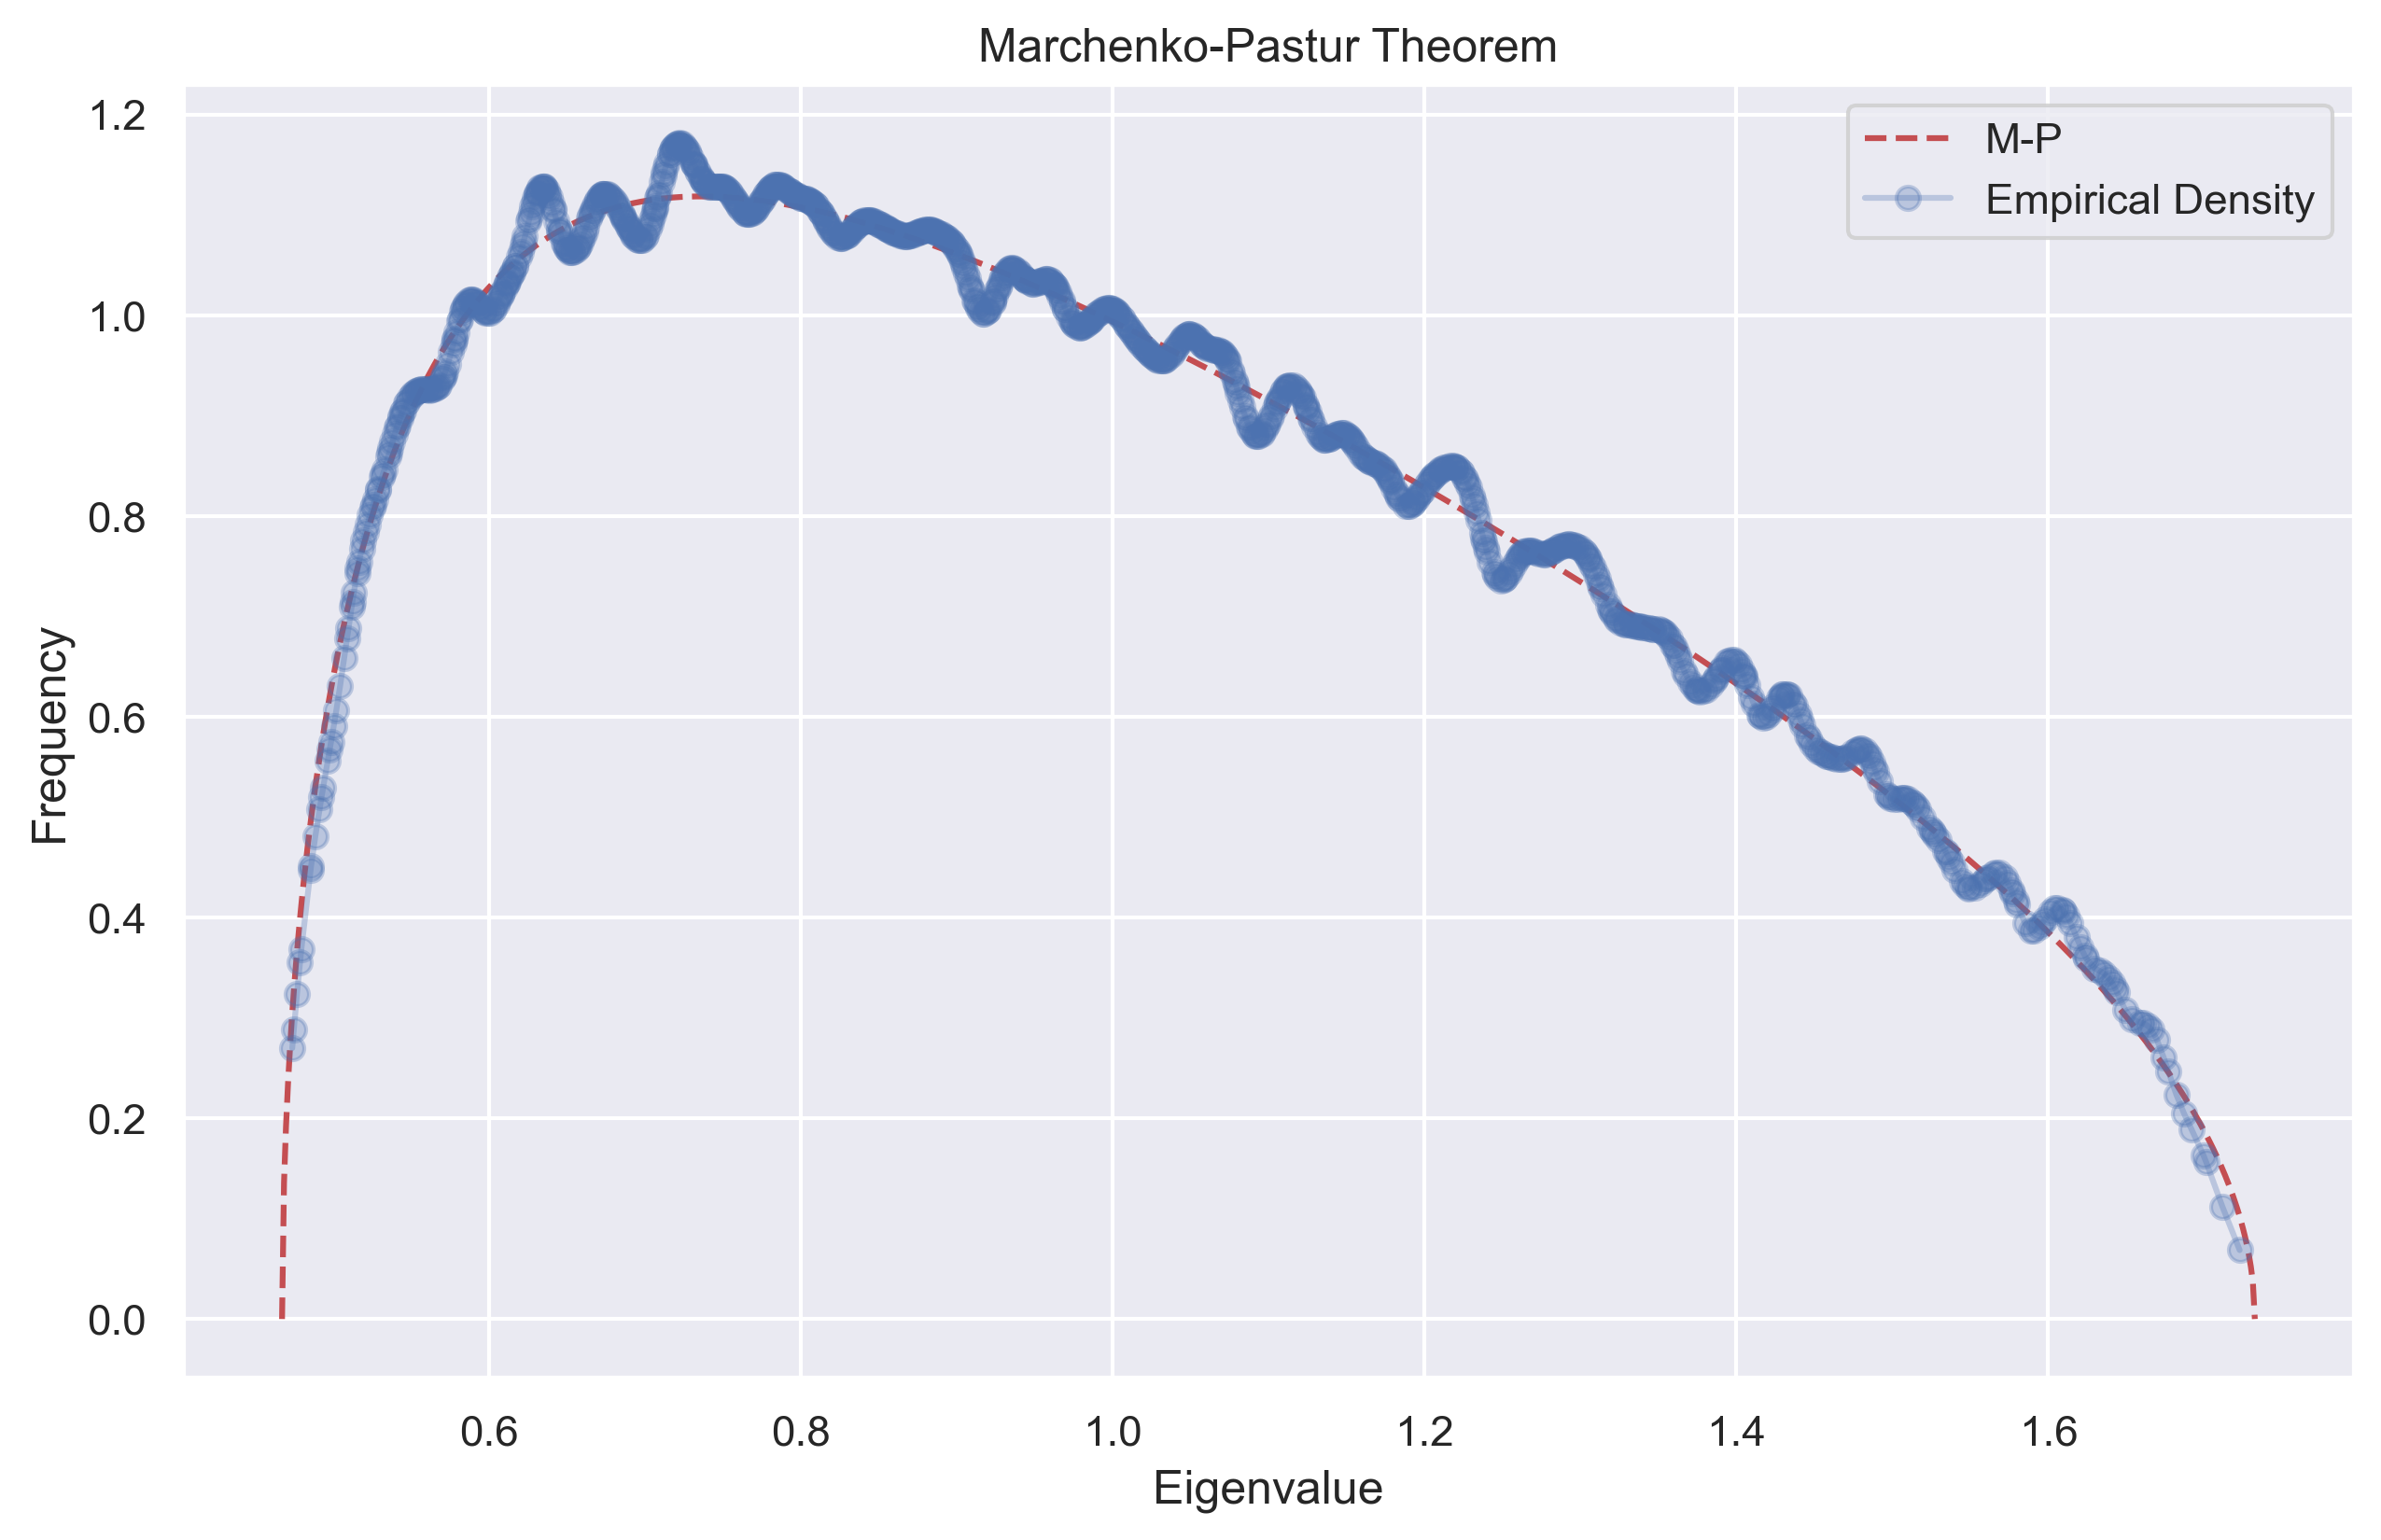

In [38]:
plotting(corr_coef, q);

## Denoising

The above are the main steps to denoise the covariance matrix so it can be used in the VaR model, which is called the *denoised VaR* estimation.

Denoising the covariance matrix includes:
  1. Calculate eigenvalues and eigenvectors of the correlation matrix
  2. Use kernel density estimation and find the eigenvector for a specific eigenvalue
  3. Fit the Marchenko-Pastur distribution to the kernel density estimation
  4. Find the max theoretical eigenvalue using the Marchenko-Pastur distribution
  5. Calculate teh average of eigenvalues greater than the theoretical value
  6. Use these new eigenvalues and eigenvectors to calculate the denoised correlation matrix
  7. Calculate the denoised covariance matrix by the new correlation matrix

In [ ]:
import portfoliolab as pl # no longer available

In [ ]:
risk_estimators = pl.estimators.RiskEstimators()

In [ ]:
stock_prices = stocks.copy()

In [ ]:
cov_matrix = stocks_returns.cov()
cov_matrix

In [ ]:
tn_relation = stock_prices.shape[0] / stock_prices.shape[1]
kde_bwidth = 0.25
cov_matrix_denoised = risk_estimators.denoise_covariance(cov_matrix,
                                                         tn_relation,
                                                         kde_bwidth)
cov_matrix_denoised = pd.DataFrame(cov_matrix_denoised,
                                   index=cov_matrix.index,
                                   columns=cov_matrix.columns)
cov_matrix_denoised

In [ ]:
def VaR_parametric_denoised(initial_investment, conf_level):
    port_std = np.sqrt(weights.T.dot(cov_matrix_denoised)
                       .dot(weights))
    alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i, j in zip(stocks.columns,range(len(stocks.columns))):
        print("Parametric VaR result for {} is {} ".format(i,VaR_param))
    VaR_params = (initial_investment - initial_investment * (1 + alpha))
    print('--' * 25)
    return VaR_params

In [ ]:
VaR_parametric_denoised(initial_investment, conf_level)

In [ ]:
symbols = ["IBM", "MSFT", "INTC"]
stock3 = []
for symbol in symbols:
    stock3.append(getDailyData(symbol)[::-1]['close']
                  ['2007-04-01': '2009-02-01'])
stocks_crisis = pd.DataFrame(stock3).T
stocks_crisis.columns = symbols

In [ ]:
stocks_crisis

In [ ]:
stock_prices = stocks_crisis.copy()

In [ ]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()

In [ ]:
cov_matrix = stocks_returns.cov()

In [ ]:
VaR_parametric(initial_investment, conf_level)

In [ ]:
VaR_parametric_denoised(initial_investment, conf_level)

The difference between a traditionally applied VaR and the denoised VaR is more pronounced in a crisis period, since correlation among assets becomes higher (referred to as *correlation breakdown*).

Despite its appeal and ease of use, VaR is not a coherent risk measure, which would require satisfying certain conditions or sxioms -- think of these as technical requirements for a risk measure.

The 4 axioms of a coherent risk measure:  

**1. Translation invariance**  
For all outcomes $Y$ and a constant $a \in \mathbb{R}$, we have $$VaR(Y + a) = VaR(Y) + a$$ which means that if a riskless amount a is added to the portfolio, it results in lowering VaR by $a$.

**2. Subadditivity**  
For all $Y_1$ and $Y_2$, we have $$VaR(Y_1 + Y_2) <= VaR(Y_1) + VaR(Y_2)$$
This axiom stresses the importance of diversification in risk management; if $Y_1$ and $Y_2$ are assets, having them in a portfolio lowers the VaR compared to having them separately.  

**3. Positive homogeneity**  
For all outcomes $Y$ and $a > 0$, we have $$VaR(aY) = aVaR(Y)$$ which implies that the risk and value of the portfolio go in tandem; if the value of a portfolio increases by amount $a$, the risk goes up by amount $a$.  

**4. Monotonicity**  
For any two outcomes, $Y_1$ and $Y_2$, we have $$VaR(Y_2) <= YaR(Y_1)$$
This is intuitive in the sense that monotonicity implies a lower VaR in the case of higher asset returns


## Checking Sub-additivity

In [ ]:
asset1 = [-0.5, 0, 0.1, 0.4]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1))
asset2 = [0, -0.5, 0.01, 0.4]
VaR2 = np.percentile(asset2, 90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2))
VaR_all = np.percentile(asset1 + asset2, 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))

In [ ]:
asset1 = [-0.5, 0, 0.05, 0.03]
VaR1 = np.percentile(asset1, 90)
print('VaR for the Asset 1 is {:.4f}'.format(VaR1))
asset2 = [0, -0.5, 0.02, 0.8]
VaR2 = np.percentile(asset2,90)
print('VaR for the Asset 2 is {:.4f}'.format(VaR2))
VaR_all = np.percentile(asset1 + asset2 , 90)
print('VaR for the portfolio is {:.4f}'.format(VaR_all))

## Expected Shortfall

In [ ]:
def ES_parametric(initial_investment , conf_level):
    alpha = - norm.ppf(1 - conf_level,stocks_returns_mean,port_std)
    for i, j in zip(stocks.columns, range(len(stocks.columns))):
        VaR_param = (initial_investment * alpha)[j]
        ES_param = (1 / (1 - conf_level)) \
                   * initial_investment \
                   * norm.expect(lambda x: x,
                                 lb = norm.ppf(conf_level,
                                               stocks_returns_mean[j],
                                               port_std),
                                 loc = stocks_returns_mean[j],
                                 scale = port_std)
        print(f"Parametric ES result for {i} is {ES_param}")

In [ ]:
ES_parametric(initial_investment, conf_level)

In [ ]:
def ES_historical(initial_investment, conf_level):
    for i, j in zip(stocks_returns.columns, 
                    range(len(stocks_returns.columns))):
        ES_hist_percentile95 = np.percentile(stocks_returns.loc[:, i],
                                             5)
        ES_historical = stocks_returns[str(i)][stocks_returns[str(i)] <=
                                               ES_hist_percentile95]\
                                               .mean()
        print("Historical ES result for {} is {:.4f} "
              .format(i, initial_investment * ES_historical))

In [ ]:
ES_historical(initial_investment, conf_level)

## Bid-Ask Spread

In [ ]:
bid_ask = pd.read_csv('bid_ask.csv')

In [ ]:
bid_ask['mid_price'] = (bid_ask['ASKHI'] + bid_ask['BIDLO']) / 2
buyer_seller_initiated = []
for i in range(len(bid_ask)):
    if bid_ask['PRC'][i] > bid_ask['mid_price'][i]:
        buyer_seller_initiated.append(1)
    else:
        buyer_seller_initiated.append(0)
        
bid_ask['buyer_seller_init'] = buyer_seller_initiated   

In [ ]:
effective_cost = []
for i in range(len(bid_ask)):
    if bid_ask['buyer_seller_init'][i] == 1:
        effective_cost.append((bid_ask['PRC'][i] - 
                               bid_ask['mid_price'][i]) / 
                               bid_ask['mid_price'][i])
    else:
        effective_cost.append((bid_ask['mid_price'][i] - 
                               bid_ask['PRC'][i])/
                               bid_ask['mid_price'][i])
bid_ask['effective_cost'] = effective_cost

In [ ]:
bid_ask['quoted'] = bid_ask['ASKHI'] - bid_ask['BIDLO']
bid_ask['prop_quoted'] = (bid_ask['ASKHI'] - bid_ask['BIDLO']) /\
                         bid_ask['mid_price']
bid_ask['effective'] = 2 * abs(bid_ask['PRC'] - bid_ask['mid_price'])
bid_ask['prop_effective'] = 2 * abs(bid_ask['PRC'] - 
                                    bid_ask['mid_price']) /\
                                    bid_ask['PRC']

In [ ]:
spread_meas = bid_ask.iloc[:, -5:]
spread_meas.corr()

In [ ]:
spread_meas.describe()

In [ ]:
high_corr = spread_meas.corr().unstack()\
            .sort_values(ascending=False).drop_duplicates()
high_corr[(high_corr > 0.80) & (high_corr != 1)]

In [ ]:
sorted_spread_measures = bid_ask.iloc[:, -5:-2]

In [ ]:
cross_sec_mean_corr = sorted_spread_measures.mean(axis=1).mean()
std_corr = sorted_spread_measures.std().sum() / 3

In [ ]:
df = pd.DataFrame(index=stocks.columns)
last_prices = []
for i in symbols:
    last_prices.append(stocks[i].iloc[-1])
df['last_prices'] = last_prices

In [ ]:
def ES_parametric(initial_investment, conf_level):
    ES_params = [ ]
    alpha = - norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
    for i,j in zip(stocks.columns,range(len(stocks.columns))):
        VaR_param = (initial_investment * alpha)[j]
        ES_param = (1 / (1 - conf_level)) \
                   * norm.expect(lambda x: VaR_param, lb = conf_level)
        ES_params.append(ES_param)
    return ES_params

In [ ]:
ES_params = ES_parametric(initial_investment, conf_level)
for i in range(len(symbols)):
    print(f'The ES result for {symbols[i]} is {ES_params[i]}')

In [ ]:
k = 1.96

for i, j in zip(range(len(symbols)), symbols):
    print('The liquidity Adjusted ES of {} is {}'
          .format(j, ES_params[i] + (df.loc[j].values[0] / 2) * 
                  (cross_sec_mean_corr + k * std_corr)))

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
spread_meas_scaled = scaler.fit_transform(np.abs(spread_meas))
pca = PCA(n_components=5)
prin_comp = pca.fit_transform(spread_meas_scaled)

In [ ]:
var_expl = np.round(pca.explained_variance_ratio_, decimals=4)
cum_var = np.cumsum(np.round(pca.explained_variance_ratio_,
                             decimals=4))
print('Individually Explained Variances are:\n{}'.format(var_expl)) 
print('=='*30)
print('Cumulative Explained Variances are: {}'.format(cum_var))  

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

In [ ]:
pca = PCA(n_components=2)
pca.fit(np.abs(spread_meas_scaled))
prin_comp = pca.transform(np.abs(spread_meas_scaled))
prin_comp = pd.DataFrame(np.abs(prin_comp), columns = ['Component 1',
                                                       'Component 2'])
print(pca.explained_variance_ratio_*100)  

In [ ]:
def myplot(score, coeff, labels=None):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    plt.scatter(xs * scalex * 4, ys * scaley * 4, s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color = 'r',
                  alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0], coeff[i, 1], "Var"+str(i),
                     color='black')
        else:
            plt.text(coeff[i,0 ], coeff[i, 1], labels[i],
                     color='black')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

In [ ]:
spread_measures_scaled_df = pd.DataFrame(spread_meas_scaled,
                                         columns=spread_meas.columns)

In [ ]:
myplot(np.array(spread_measures_scaled_df)[:, 0:2], 
       np.transpose(pca.components_[0:2,:]), 
       list(spread_measures_scaled_df.columns))
plt.show()

In [ ]:
prin_comp1_rescaled = prin_comp.iloc[:,0] * prin_comp.iloc[:,0].std()\
                      + prin_comp.iloc[:, 0].mean()
prin_comp2_rescaled = prin_comp.iloc[:,1] * prin_comp.iloc[:,1].std()\
                      + prin_comp.iloc[:, 1].mean()
prin_comp_rescaled = pd.concat([prin_comp1_rescaled, 
                                prin_comp2_rescaled],
                               axis=1)
prin_comp_rescaled.head()

In [ ]:
mean_pca_liq = prin_comp_rescaled.mean(axis=1).mean()
mean_pca_liq

In [ ]:
k = 1.96
for i, j in zip(range(len(symbols)), symbols):
    print('The liquidity Adjusted ES of {} is {}'
          .format(j, ES_params[i] + (df.loc[j].values[0] / 2) * 
                  (mean_pca_liq + k * std_corr)))